In [81]:
from IPython import get_ipython
get_ipython().magic('reset -sf')
from utils import *
import configs
low_level_feature_file = "smp_all_set_llfeat.pkl"
globals().update(dill.load(open(low_level_feature_file, "rb")))
print(smp_data.sample(2).drop(columns=['image_path']).to_string())
smp_data = smp_data.drop(columns=['all_tags_uppercase_count'])
print(smp_data.columns)
print("columns with kinds num:", {col: smp_data[col].nunique() for col in smp_data.columns})
# 将dtype为object的列都转化为str，如果为None就填入''
for column in smp_data.select_dtypes(include=['object']).columns:
    smp_data[column] = smp_data[column].astype(pd.StringDtype()).replace('None', '')

# 'Ispublic', 'Pid', 'Postdate'列尝试改为int
smp_data['Postdate'] = smp_data['Postdate'].astype(int)
smp_data['ispro'] = smp_data['ispro'].astype(pd.StringDtype()).replace('None', '')
smp_data['Ispublic'] = smp_data['Ispublic'].astype(pd.StringDtype()).replace('None', '')
smp_data['Pid'] = smp_data['Pid'].astype(pd.StringDtype()).replace('None', '')

# 'Longitude', 'Geoaccuracy', 'Latitude'列如果是空字符串就填入均值，改成float64
for column in ['Longitude', 'Geoaccuracy', 'Latitude']:
    smp_data[column] = smp_data[column].replace('', np.nan).astype(float)
    smp_data[column].fillna(smp_data[column].mean(), inplace=True)

# 'photo_firstdate'列改成以秒为单位的数值，空字符串填入均值
smp_data['photo_firstdate'] = pd.to_datetime(smp_data['photo_firstdate'], errors='coerce')
smp_data['photo_firstdate'] = smp_data['photo_firstdate'].apply(lambda x: x.timestamp() if pd.notnull(x) else np.nan)
smp_data['photo_firstdate'].fillna(smp_data['photo_firstdate'].mean(), inplace=True)

# 'timezone_offset'改成int，空字符串填入均值
smp_data['timezone_offset'] = smp_data['timezone_offset'].replace('', np.nan)
smp_data['timezone_offset'] = smp_data['timezone_offset'].apply(lambda x: int(x[:3]) if pd.notnull(x) else np.nan)
smp_data['timezone_offset'].fillna(smp_data['timezone_offset'].mean(), inplace=True)

# 'photo_firstdatetaken'改成以秒为单位的数值，空字符串填入均值
smp_data['photo_firstdatetaken'] = pd.to_datetime(smp_data['photo_firstdatetaken'], errors='coerce')
smp_data['photo_firstdatetaken'] = smp_data['photo_firstdatetaken'].apply(lambda x: x.timestamp() if pd.notnull(x) else np.nan)
smp_data['photo_firstdatetaken'].fillna(smp_data['photo_firstdatetaken'].mean(), inplace=True)
# 遍历所有数值特征，判断是否有一个值占比在80%以上
numeric_features = smp_data.select_dtypes(include=[np.number]).columns
for feature in numeric_features:
    if feature == 'label':
        continue
    # 新增缺失值填充
    smp_data[feature].fillna(smp_data[feature].mean(), inplace=True)
    # 计算每个值的占比
    value_counts = smp_data[feature].value_counts(normalize=True)
    # 判断是否有一个值占比在80%以上
    if value_counts.iloc[0] >= 0.8:
        special_value = value_counts.index[0]
        new_column_name = f"{feature}_spv"
        smp_data[new_column_name] = (smp_data[feature] == special_value).astype(int)

# 对所有数值特征做IQR计算，并进行处理
for feature in numeric_features:
    if feature == 'label':
        continue
    # 用Z-score标准化
    mean = smp_data[feature].mean()
    std = smp_data[feature].std()
    smp_data[feature] = (smp_data[feature] - mean) / std

# 效应量分析代码
Effective_size = {}

for column_name in smp_data.columns:
    if column_name == "label":
        continue
    
    data = smp_data[column_name]
    label = smp_data["label"]

    if pd.api.types.is_numeric_dtype(data):
        # 对于数值特征，采用 Cohen's d 效应量分析
        data_analysis = data.dropna().reset_index(drop=True)
        lower_quantile = data_analysis.quantile(0.25)
        upper_quantile = data_analysis.quantile(0.75)
        group_1 = data_analysis[data_analysis <= lower_quantile]
        group_2 = data_analysis[data_analysis >= upper_quantile]

        # 计算 Cohen's d 效应量
        mean_1 = group_1.mean()
        mean_2 = group_2.mean()
        std_1 = group_1.std()
        std_2 = group_2.std()
        pooled_std = np.sqrt(((len(group_1) - 1) * std_1**2 + (len(group_2) - 1) * std_2**2) / (len(group_1) + len(group_2) - 2))
        cohen_d = (mean_1 - mean_2) / pooled_std

        # 计算 p 值
        t_stat, p_value = stats.ttest_ind(group_1, group_2, equal_var=False)

        # 存储结果
        Effective_size[column_name] = {"method": "Cohen's d", "effect_size": cohen_d, "p_value": p_value}
        print(f"{column_name} Cohen's d effect size: {cohen_d}, p-value: {p_value}")

    else:
        # 对于类别特征，采用 Cramér's V 效应量分析
        contingency_table = pd.crosstab(data, label)
        chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
        n = contingency_table.sum().sum()  # 样本量
        cramers_v = np.sqrt(chi2 / (n * (min(contingency_table.shape) - 1)))

        # 存储结果
        Effective_size[column_name] = {"method": "Cramér's V", "effect_size": cramers_v, "p_value": p}
        print(f"{column_name} Cramér's V effect size: {cramers_v}, p-value: {p}")
        
# 按方法分组并排序
method_groups = {
    "Cohen's d": [],
    "Cramér's V": []
}

for col, info in Effective_size.items():
    group = method_groups[info["method"]]
    group.append((col, info["effect_size"], info["p_value"]))

# 定义排序函数（处理nan值）
def sort_key(item):
    effect_size = item[1]
    if np.isnan(effect_size):
        return (float('inf'),)  # 将nan放在最后
    return (-abs(effect_size), -effect_size)  # 先按绝对值降序，再按实际值降序

# 分组排序并打印
for method, group in method_groups.items():
    sorted_group = sorted(group, key=sort_key)
    print(f"\n=== {method} 效应量排序结果 ===")
    for col, es, p in sorted_group:
        nan_flag = "(包含NaN)" if np.isnan(es) or np.isnan(p) else ""
        print(f"{col}: {es:.4f} (p={p:.4f}) {nan_flag}")

# smp_data_backup = smp_data.copy()
# smp_data = smp_data.drop(columns=[column_name for column_name, effect_size in Effective_size.items() if np.isnan(effect_size["p_value"]) or effect_size["p_value"] > 0.05])

/var/folders/w9/pwn3f5_956q3433d95gyj2900000gn/T/ipykernel_39491/378117167.py:2: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic('reset -sf')


        label              category   subcategory Mediastatus       Pathalias Ispublic     Pid        Uid    Postdate Longitude Geoaccuracy Latitude photo_firstdate  photo_count  ispro timezone_offset photo_firstdatetaken                 timezone_id                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               

In [82]:
def print_full_latex_table():
    # 初始化存储容器
    cohen_entries = []
    cramer_entries = []
    
    # 处理每个特征
    for feature, info in Effective_size.items():
        # 生成显示名称
        display_name = feature.replace('title_', 't_').replace('user_description_', 'ud_').replace('all_tags_', 'at_')
        display_name = display_name.replace('_', r'\_')
        
        # 构建条目
        entry = {
            'name': display_name,
            'effect': abs(info['effect_size']),
            'effect_raw': info['effect_size'],
            'method': info['method'],
            'abs_effect': abs(info['effect_size']),
            'p_value': info['p_value']  # 新增p值字段
        }
        
        if info['method'] == "Cohen's d":
            cohen_entries.append(entry)
        else:
            cramer_entries.append(entry)
    
    # 新增排序逻辑 ====================================
    cohen_entries = sorted(cohen_entries, key=lambda x: x['abs_effect'], reverse=True)
    cramer_entries = sorted(cramer_entries, key=lambda x: x['effect'], reverse=True)
    
    # 打印完整表格
    print(r'''\setlength{\tabcolsep}{0.1pt}
\renewcommand{\arraystretch}{1.0}

\begin{longtable}{@{\extracolsep{\fill}}cccccc@{}}
    \caption{Effect Size Analysis Results with Feature Abbreviations 
    (t: title, ud: user\_description, at: all\_tags; Sig.: p ≤ 0.01; 
    Cohen's d: S.(|d|≥0.7), M.(0.4≤|d|<0.7), W.(|d|<0.4); 
    Cramér's V: S.(V≥0.4), M.(0.2≤V<0.4), W.(V<0.2)). Suffix indicators (e.g. \_spv) 
    denote binary features created when a single value accounts for >80\% prevalence.}
    \label{tab:full_effects} \\
    \toprule
    \textbf{Feature Name} & \textbf{Effect Size} & \textbf{Type} & 
    \textbf{Feature Name} & \textbf{Effect Size} & \textbf{Type} \\
    \midrule
    \endfirsthead''')

    # 打印Cohen's d部分
    print(r'    \multicolumn{6}{c}{\textbf{Cohen\'s d (Continuous)}} \\')
    for i in range(0, len(cohen_entries), 2):
        left = cohen_entries[i]
        right = cohen_entries[i+1] if i+1 < len(cohen_entries) else None
        
        # 添加显著性判断
        left_sig = 'Sig.' if left['p_value'] <= 0.01 else 'Not Sig.'
        right_sig = 'Sig.' if right and right['p_value'] <= 0.01 else 'Not Sig.' if right else ''
        
        line = f"{left['name']} & {left['effect_raw']:.3f} & {'S.' if left['abs_effect']>=0.7 else 'M.' if left['abs_effect']>=0.4 else 'W.'} {left_sig}"
        if right:
            line += f" & {right['name']} & {right['effect_raw']:.3f} & {'S.' if right['abs_effect']>=0.7 else 'M.' if right['abs_effect']>=0.4 else 'W.'} {right_sig}"
        else:
            line += " & & &"
        print(f"    {line} \\\\")

    # 打印Cramér's V部分
    print(r'    \multicolumn{6}{c}{\textbf{Cramér\'s V (Categorical)}} \\')
    for i in range(0, len(cramer_entries), 2):
        left = cramer_entries[i]
        right = cramer_entries[i+1] if i+1 < len(cramer_entries) else None
        
        # 修改显著性显示逻辑
        left_sig = 'Sig.' if left['p_value'] <= 0.01 else 'Not Sig.'
        right_sig = 'Sig.' if right and right['p_value'] <= 0.01 else 'Not Sig.' if right else ''
        
        line = f"{left['name']} & {left['effect']:.3f} & {'S.' if left['effect']>=0.4 else 'M.' if left['effect']>=0.2 else 'W.'} {left_sig}"
        if right:
            line += f" & {right['name']} & {right['effect']:.3f} & {'S.' if right['effect']>=0.4 else 'M.' if right['effect']>=0.2 else 'W.'} {right_sig}"
        else:
            line += " & & &"
        print(f"    {line} \\\\")

    print(r'''    \bottomrule
\end{longtable}''')

# 执行打印
print_full_latex_table()

\setlength{\tabcolsep}{0.1pt}
\renewcommand{\arraystretch}{1.0}

\begin{longtable}{@{\extracolsep{\fill}}cccccc@{}}
    \caption{Effect Size Analysis Results with Feature Abbreviations 
    (t: title, ud: user\_description, at: all\_tags; Sig.: p ≤ 0.01; 
    Cohen's d: S.(|d|≥0.7), M.(0.4≤|d|<0.7), W.(|d|<0.4); 
    Cramér's V: S.(V≥0.4), M.(0.2≤V<0.4), W.(V<0.2)). Suffix indicators (e.g. \_spv) 
    denote binary features created when a single value accounts for >80\% prevalence.}
    \label{tab:full_effects} \\
    \toprule
    \textbf{Feature Name} & \textbf{Effect Size} & \textbf{Type} & 
    \textbf{Feature Name} & \textbf{Effect Size} & \textbf{Type} \\
    \midrule
    \endfirsthead
    \multicolumn{6}{c}{\textbf{Cohen\'s d (Continuous)}} \\
    t\_noun\_ratio & -51.919 & S. Sig. & ud\_unique\_word\_ratio & -15.407 & S. Sig. \\
    ud\_stopword\_ratio & -8.622 & S. Sig. & Postdate & -7.600 & S. Sig. \\
    ud\_avg\_word\_length & -7.384 & S. Sig. & hue\_mean & -5.717 & S. Sig. 

In [84]:
# 独立打印代码段 ========================================
weak_features = []
moderate_features = []
not_significant_features = []

for feature, info in Effective_size.items():
    # 转换特征名为原始格式
    original_name = (
        feature.replace('title_', 't_')
               .replace('user_description_', 'ud_')
               .replace('all_tags_', 'at_')
    )
    
    # 判断显著性
    if info['p_value'] > 0.01:
        not_significant_features.append(original_name)
        continue
    
    # 判断效应量强度
    if info['method'] == "Cohen's d":
        effect = abs(info['effect_size'])
        if 0.4 <= effect < 0.7:
            moderate_features.append(original_name)
        elif effect < 0.4:
            weak_features.append(original_name)
    else:
        effect = info['effect_size']
        if 0.2 <= effect < 0.4:
            moderate_features.append(original_name)
        elif effect < 0.2:
            weak_features.append(original_name)

# 打印结果
print("\n=== 独立特征分类结果 ===")
print(f"弱效应显著特征 ({len(weak_features)}): {weak_features}")
print(f"中等效应显著特征 ({len(moderate_features)}): {moderate_features}") 
print(f"不显著特征 ({len(not_significant_features)}): {not_significant_features}")

smp_data_bk = smp_data.copy()


=== 独立特征分类结果 ===
弱效应显著特征 (18): ['category', 'subcategory', 'photo_firstdate', 'photo_count', 'ispro', 'timezone_id', 'location_description', 'concept', 'media_type', 't_verb_ratio', 'at_punctuation_count', 'at_stopword_ratio', 'at_unique_word_ratio', 'photo_firstdate_spv', 't_verb_ratio_spv', 'at_punctuation_count_spv', 'at_stopword_ratio_spv', 'at_unique_word_ratio_spv']
中等效应显著特征 (11): ['Pathalias', 'Longitude', 'Geoaccuracy', 'Latitude', 'ASM', 't_stopword_ratio', 't_unique_word_ratio', 'Longitude_spv', 'Geoaccuracy_spv', 'Latitude_spv', 't_unique_word_ratio_spv']
不显著特征 (4): ['image_path', 'Mediastatus', 'Ispublic', 'Pid']


In [85]:
smp_data = smp_data_bk.copy()

def analyze_feature_importance(features):
    reverse_mapping = {
        't_': 'title_',
        'ud_': 'user_description_',
        'at_': 'all_tags_'
    }
    
    # Convert display names to original column names
    original_features = []
    for f in features:
        # Unescape LaTeX underscores
        original_name = f.replace(r'\_', '_')
        # Restore feature prefixes
        for short, full in reverse_mapping.items():
            if original_name.startswith(short):
                original_name = original_name.replace(short, full, 1)
                break
        original_features.append(original_name)
    
    na_features = []

    results = []
    for display_name, orig_name in zip(features, original_features):
        # Check column existence
        if orig_name not in smp_data.columns:
            print(f"Warning: Column '{orig_name}' not found, skipping...")
            continue
            
        # Feature type detection
        is_categorical = smp_data[orig_name].nunique() < 100
        
        # Chi-square Test
        chi2_result = 'N/A'
        if is_categorical:
            try:
                contingency_table = pd.crosstab(smp_data[orig_name], smp_data['label'])
                if contingency_table.shape[0] > 1:
                    _, p, _, _ = chi2_contingency(contingency_table)
                    chi2_result = 'Strong' if p < 0.01 else 'Moderate' if p < 0.05 else 'Weak'
            except:
                pass
        
        # ANOVA Test
        anova_result = 'N/A'
        if is_categorical:
            try:
                categories = smp_data[orig_name].unique()
                if len(categories) >= 2:
                    groups = [smp_data[smp_data[orig_name] == c]['label'] for c in categories]
                    _, p = f_oneway(*groups)
                    anova_result = 'Strong' if p < 0.01 else 'Moderate' if p < 0.05 else 'Weak'
            except:
                pass
        
        # Model Importance
        tree_strength = 'N/A'
        rf_strength = 'N/A'
        try:
            X = smp_data[[orig_name]]
            y = smp_data['label']
            
            # Decision Tree
            tree = DecisionTreeRegressor(max_depth=3)
            tree.fit(X, y)
            tree_imp = tree.feature_importances_[0]
            tree_strength = 'Strong' if tree_imp > 0.3 else 'Moderate' if tree_imp > 0.1 else 'Weak'
            
            # Random Forest
            rf = RandomForestRegressor(n_estimators=50)
            rf.fit(X, y)
            rf_imp = rf.feature_importances_[0]
            rf_strength = 'Strong' if rf_imp > 0.3 else 'Moderate' if rf_imp > 0.1 else 'Weak'
        except:
            pass
        
        # Escape underscores for LaTeX
        latex_name = display_name.replace('_', r'\_')
        
        # 结果格式化处理
        # 处理模型重要性为N/A的情况
        if tree_strength == 'N/A' and rf_strength == 'N/A':
            model_display = 'Not Numeric'  # 去掉了加粗
            chi2_display = 'Too many unique values' if chi2_result == 'N/A' else f'\\textbf{{{chi2_result}}}'
            anova_display = 'Too many unique values' if anova_result == 'N/A' else f'\\textbf{{{anova_result}}}'
        else:
            # 处理统计检验结果
            chi2_display = 'Too many unique values' if chi2_result == 'N/A' else f'\\textbf{{{chi2_result}}}'
            anova_display = 'Too many unique values' if anova_result == 'N/A' else f'\\textbf{{{anova_result}}}'
            # 合并模型结果
            model_display = f"\\textbf{{{tree_strength}}}/\\textbf{{{rf_strength}}}" 
            if tree_strength == rf_strength:
                model_display = f'\\textbf{{{tree_strength}}}'
        
        if chi2_result == 'N/A' and tree_strength == 'N/A' and rf_strength == 'N/A':
            na_features.append(display_name)

        results.append({
            'Feature': latex_name,
            'Chi-square': chi2_display,
            'ANOVA': anova_display,
            'Tree-based': model_display
        })
    
    # Generate LaTeX table
    df = pd.DataFrame(results)
    latex_code = df.to_latex(index=False, 
                     caption="Feature Importance Analysis",
                     label="tab:feature_importance",
                     column_format="lccc",
                     escape=False)
    
    # 添加表格居中设置
    latex_code = latex_code.replace(r'\begin{table}', r'\begin{table}\centering')
    
    print(r"""\begingroup
\setlength{\tabcolsep}{6pt}
\renewcommand{\arraystretch}{1}
""")
    print(latex_code)
    print(r"\endgroup")

    return na_features

# 使用示例（必须传入转换后的特征名）
na_features = analyze_feature_importance(weak_features + moderate_features)

print("Delete: ", not_significant_features + na_features)
smp_data = smp_data_bk.drop(columns=not_significant_features + na_features)

\begingroup
\setlength{\tabcolsep}{6pt}
\renewcommand{\arraystretch}{1}

\begin{table}\centering
\caption{Feature Importance Analysis}
\label{tab:feature_importance}
\begin{tabular}{lccc}
\toprule
Feature & Chi-square & ANOVA & Tree-based \\
\midrule
category & \textbf{Strong} & \textbf{Strong} & Not Numeric \\
subcategory & \textbf{Strong} & \textbf{Strong} & Not Numeric \\
photo\_firstdate & Too many unique values & Too many unique values & \textbf{Strong} \\
photo\_count & Too many unique values & Too many unique values & \textbf{Strong} \\
ispro & \textbf{Strong} & \textbf{Weak} & Not Numeric \\
timezone\_id & \textbf{Strong} & \textbf{Weak} & Not Numeric \\
location\_description & Too many unique values & Too many unique values & Not Numeric \\
concept & Too many unique values & Too many unique values & Not Numeric \\
media\_type & \textbf{Strong} & \textbf{Strong} & Not Numeric \\
t\_verb\_ratio & Too many unique values & Too many unique values & \textbf{Strong} \\
at\_punctuatio

['Postdate', 'Longitude', 'Geoaccuracy', 'Latitude', 'photo_firstdate', 'photo_count', 'timezone_offset', 'photo_firstdatetaken', 'red_mean', 'green_mean', 'blue_mean', 'red_std', 'green_std', 'blue_std', 'hue_mean', 'saturation_mean', 'value_mean', 'hue_std', 'saturation_std', 'value_std', 'contrast', 'homogeneity', 'energy', 'entropy', 'correlation', 'ASM', 'dissimilarity', 'title_char_count', 'title_word_count', 'title_avg_word_length', 'title_punctuation_count', 'title_uppercase_count', 'title_digit_count', 'title_stopword_ratio', 'title_noun_ratio', 'title_verb_ratio', 'title_unique_word_ratio', 'title_avg_sentence_length', 'user_description_char_count', 'user_description_word_count', 'user_description_avg_word_length', 'user_description_punctuation_count', 'user_description_uppercase_count', 'user_description_digit_count', 'user_description_stopword_ratio', 'user_description_noun_ratio', 'user_description_verb_ratio', 'user_description_unique_word_ratio', 'user_description_avg_se

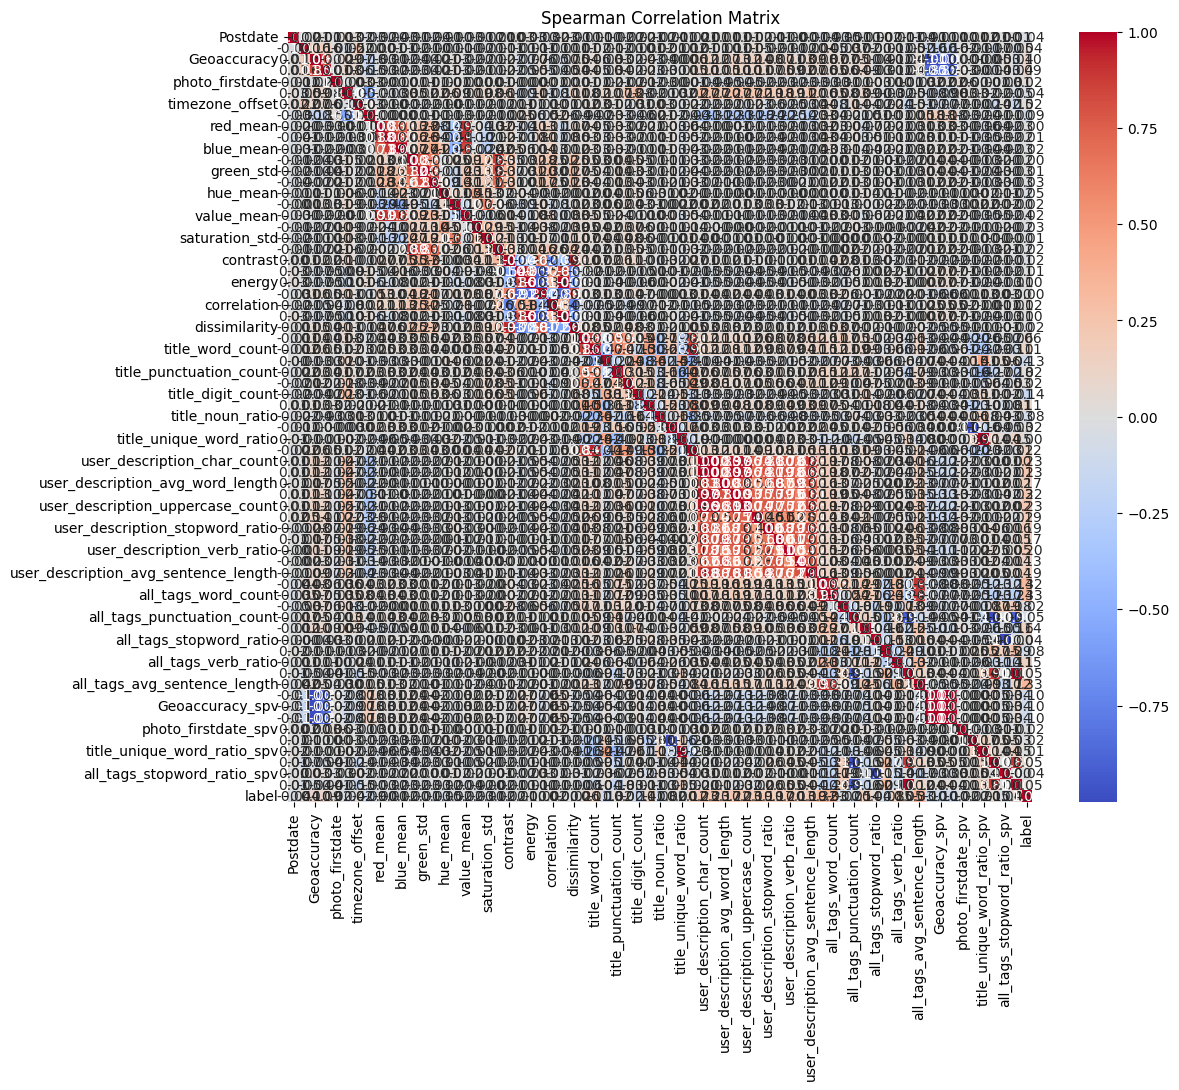

0
0
                            OLS Regression Results                            
Dep. Variable:                  label   R-squared:                       0.200
Model:                            OLS   Adj. R-squared:                  0.200
Method:                 Least Squares   F-statistic:                     1125.
Date:                Sun, 09 Mar 2025   Prob (F-statistic):               0.00
Time:                        23:54:03   Log-Likelihood:            -6.7622e+05
No. Observations:              305613   AIC:                         1.353e+06
Df Residuals:                  305544   BIC:                         1.353e+06
Df Model:                          68                                         
Covariance Type:            nonrobust                                         
                                           coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

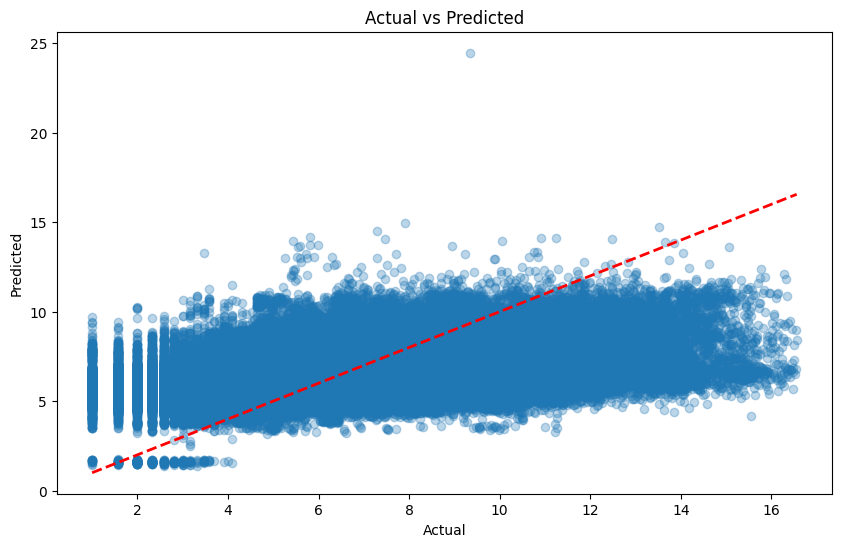

Mean Squared Error (MSE) for Ridge Regression: 4.886882480449868
                                      Coefficient  Std Error  p value
const                                    0.000000   0.147067 1.000000
Postdate                                -0.115996   0.004535 0.000000
Longitude                                0.031093   0.004729 0.000000
Geoaccuracy                             -0.824755   0.044153 0.000000
Latitude                                 0.068244   0.009090 0.000000
photo_firstdate                          0.047247   0.004475 0.000000
photo_count                             -0.118672   0.004532 0.000000
timezone_offset                          0.038942   0.004703 0.000000
photo_firstdatetaken                    -0.024597   0.004709 0.000000
red_mean                                 0.039092   0.019934 0.049878
green_mean                              -0.265300   0.018555 0.000000
blue_mean                               -0.020493   0.020845 0.325550
red_std                  

In [ ]:
import seaborn as sns
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
from sklearn.linear_model import Ridge

# 相关分析
numeric_features = smp_data.select_dtypes(include=[np.number]).columns.tolist()
numeric_features.remove('label')

correlation_matrix = smp_data[numeric_features + ['label']].corr(method='spearman')

# 如果某一行都是空值，那么把这一行对应的特征名称输出
empty_rows = []
for i in range(correlation_matrix.shape[0]):
    if correlation_matrix.iloc[i].isna().all():
        print(f"特征 {correlation_matrix.index[i]} 的相关性矩阵行全为空值")
        empty_rows.append(correlation_matrix.index[i])

# 删除全为空值的行和列
correlation_matrix = correlation_matrix.drop(index=empty_rows, columns=empty_rows)

smp_data = smp_data.drop(columns=empty_rows)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Spearman Correlation Matrix")
plt.show()

# 回归分析
numeric_features = smp_data.select_dtypes(include=[np.number]).columns.tolist()
numeric_features.remove('label')
X = smp_data[numeric_features]
y = smp_data['label']

# 处理缺失值和无穷值
X = X.replace([np.inf, -np.inf], np.nan)
X = X.dropna(axis=1, how='any')

# 检查是否为空
if X.empty:
    raise ValueError("处理缺失值后，数据集为空，无法进行回归分析。")

# 添加常数项
X = sm.add_constant(X)

# 使用 statsmodels 进行线性回归分析
linear_model = sm.OLS(y, X).fit()
print(linear_model.summary())

# 使用 statsmodels 进行泊松回归分析
poisson_model = sm.GLM(y, X, family=sm.families.Poisson()).fit()
print(poisson_model.summary())

from sklearn.metrics import mean_squared_error

# 获取线性回归的预测值
y_pred_poisson = linear_model.predict(X)
# 计算泊松回归的 MSE
mse_poisson = mean_squared_error(y, y_pred_poisson)
print(f'Mean Squared Error (MSE) for Linear Regression: {mse_poisson}')

# 获取泊松回归的预测值
y_pred_poisson = poisson_model.predict(X)
# 计算泊松回归的 MSE
mse_poisson = mean_squared_error(y, y_pred_poisson)
print(f'Mean Squared Error (MSE) for Poisson Regression: {mse_poisson}')

# 可视化回归结果
plt.figure(figsize=(10, 6))
plt.scatter(y, y_pred_poisson, alpha=0.3)
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

from scipy.stats import t
from sklearn.metrics import mean_squared_error

# 数据拆分
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# 初始化岭回归
alpha = 1.0
ridge = Ridge(alpha=alpha)
ridge.fit(X_train, y_train)

# 获取岭回归系数
coefs = ridge.coef_
intercept = ridge.intercept_

# 计算预测值和残差
y_pred = ridge.predict(X_train)
residuals = y_train - y_pred

mse_ridge = mean_squared_error(y_train, y_pred)
print(f'Mean Squared Error (MSE) for Ridge Regression: {mse_ridge}')

# 手动计算标准误差 (粗略估计)
n_features = X.shape[1]
sigma_squared = np.var(residuals, ddof=n_features + 1)
XTX_inv = np.linalg.inv(X_train.T @ X_train + alpha * np.eye(n_features))
std_err = np.sqrt(np.diag(sigma_squared * XTX_inv))

# 计算 t 值
t_values = coefs / std_err

# 样本数量和自由度
n_samples = X_train.shape[0]
df = n_samples - n_features - 1  # 自由度

# 计算 p 值
p_values = [2 * (1 - t.cdf(np.abs(t_val), df)) for t_val in t_values]

# 构造回归结果表格
results = pd.DataFrame({
    'Coefficient': coefs,
    'Std Error': std_err,
    # 't value': t_values,
    'p value': p_values
}, index=[f'{X.columns.to_list()[i]}' for i in range(n_features)])

# 设置 Pandas 显示选项
pd.set_option("display.max_rows", None)  # 显示所有行
pd.set_option("display.float_format", "{:.6f}".format)  # 禁用科学计数法并显示为小数

# 打印表格
print(results)

# 恢复默认选项
pd.reset_option("display.max_rows")
pd.reset_option("display.float_format")

# 在相关分析之后添加结果收集
results_list = []

# 收集Spearman相关系数
spearman_corrs = correlation_matrix['label'].drop('label', errors='ignore')
for feature in numeric_features:
    if feature in spearman_corrs:
        results_list.append({
            'Feature': feature,
            'Spearman': spearman_corrs[feature],
            'Linear Coef': np.nan,
            'Linear p': np.nan,
            'Poisson Coef': np.nan,
            'Poisson p': np.nan,
            'Ridge Coef': np.nan,
            'Ridge p': np.nan
        })

# 填充线性回归结果
for idx, coef in enumerate(linear_model.params.index):
    if coef != 'const':
        for item in results_list:
            if item['Feature'] == coef:
                item.update({
                    'Linear Coef': linear_model.params[idx],
                    'Linear p': linear_model.pvalues[idx]
                })

# 填充泊松回归结果
for idx, coef in enumerate(poisson_model.params.index):
    if coef != 'const':
        for item in results_list:
            if item['Feature'] == coef:
                item.update({
                    'Poisson Coef': poisson_model.params[idx],
                    'Poisson p': poisson_model.pvalues[idx]
                })

# 填充岭回归结果
ridge_coefs = pd.Series(ridge.coef_, index=X.columns)
for idx, coef_name in enumerate(X.columns):
    if coef_name != 'const':
        for item in results_list:
            if item['Feature'] == coef_name:
                item.update({
                    'Ridge Coef': ridge_coefs[idx],
                    'Ridge p': p_values[idx]
                })


# 修改结果收集部分（添加p值判断）
results_list = []

# 收集Spearman相关系数和p值
for feature in numeric_features:
    if feature in correlation_matrix['label']:
        corr = correlation_matrix['label'][feature]
        # 计算Spearman p值
        from scipy.stats import spearmanr
        sp_p = spearmanr(smp_data[feature], y).pvalue
        results_list.append({
            'Feature': feature,
            'Spearman': f"{corr:.2f}{'*' * sum([sp_p < t for t in [0.1, 0.05, 0.01]])}",
            'Linear': f"{linear_model.params[feature]:.2f}{'*' * sum([linear_model.pvalues[feature] < t for t in [0.1, 0.05, 0.01]])}",
            'Poisson': f"{poisson_model.params[feature]:.2f}{'*' * sum([poisson_model.pvalues[feature] < t for t in [0.1, 0.05, 0.01]])}",
            'Ridge': f"{ridge_coefs[feature]:.2f}{'*' * sum([p_values[idx] < t for t in [0.1, 0.05, 0.01]])}"
        })

# 生成结果DataFrame并格式化
results_df = pd.DataFrame(results_list)

# 生成LaTeX表格（5列格式）
latex_table = results_df.to_latex(
    index=False,
    caption="Feature Statistics Summary with Significance Stars (*p<0.1, **p<0.05, ***p<0.01)",
    label="tab:feature_stats",
    column_format="lcccc",
    formatters={
        'Feature': lambda x: x.replace('_', ' ').replace(' ', '_')
                            .replace('title', 't')
                            .replace('user_description', 'ud')
                            .replace('all_tags', 'at')
                            .replace('words', 'w')
                            .replace('characters', 'c')
                            .replace('_spv', ''),
    },
    escape=False,
    longtable=True
)

# 优化 LaTeX 结构
latex_table = (
    latex_table
    .replace('_', r'\_')
    .replace(r'\begin{longtable}', r'\begin{center}\begin{longtable}')
    .replace(r'\end{longtable}', r'\end{longtable}\end{center}')
    .replace(r'\toprule', r'\hline')
    .replace(r'\midrule', r'\hline')
    .replace(r'\bottomrule', r'\hline')
)

print("\setlength{\tabcolsep}{4pt}")
print(latex_table)

In [87]:
print("泊松模型的分散比（均值 / 方差）:", y.mean() / y.var())

泊松模型的分散比（均值 / 方差）: 1.0473786211432279


In [88]:
print(smp_data.columns)

Index(['label', 'category', 'subcategory', 'Uid', 'Postdate', 'Longitude',
       'Geoaccuracy', 'Latitude', 'photo_firstdate', 'photo_count', 'ispro',
       'timezone_offset', 'photo_firstdatetaken', 'timezone_id',
       'user_description', 'all_tags', 'media_type', 'title', 'red_mean',
       'green_mean', 'blue_mean', 'red_std', 'green_std', 'blue_std',
       'hue_mean', 'saturation_mean', 'value_mean', 'hue_std',
       'saturation_std', 'value_std', 'contrast', 'homogeneity', 'energy',
       'entropy', 'correlation', 'ASM', 'dissimilarity', 'title_char_count',
       'title_word_count', 'title_avg_word_length', 'title_punctuation_count',
       'title_uppercase_count', 'title_digit_count', 'title_stopword_ratio',
       'title_noun_ratio', 'title_verb_ratio', 'title_unique_word_ratio',
       'title_avg_sentence_length', 'user_description_char_count',
       'user_description_word_count', 'user_description_avg_word_length',
       'user_description_punctuation_count',
       '

In [117]:
# 尝试使用gpu加速
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
# device = "cpu"
print("device: ", device)
# print("这里可以用mps加速，但是实测下来，由于网络太小了，gpu并行计算优势不大，不如cpu速度快。")

# 数据预处理函数
def preprocess_data(smp_data):
    # 处理数值特征
    numeric_features = smp_data.select_dtypes(include=[np.number]).columns.tolist()
    numeric_features.remove('label')
    scaler = StandardScaler()
    smp_data[numeric_features] = scaler.fit_transform(smp_data[numeric_features])

    # 获取类别特征
    categorical_columns = smp_data.select_dtypes(include=['object']).columns.tolist()
    
    # 对类别特征使用LabelEncoder
    label_encoder = LabelEncoder()
    for column in categorical_columns:
        smp_data[column] = label_encoder.fit_transform(smp_data[column].fillna('missing').astype(str))

    return smp_data, numeric_features, categorical_columns

# 预处理数据
smp_data, numeric_features, categorical_columns = preprocess_data(smp_data)

# 特征和标签
Y = smp_data['label']
X_image = smp_data[['category', 'subcategory', 'red_mean', 'green_mean', 'blue_mean', 'red_std', 
                    'green_std', 'blue_std', 'hue_mean', 'saturation_mean', 'value_mean', 'hue_std', 
                    'saturation_std', 'value_std', 'contrast', 'homogeneity', 'energy', 'entropy', 
                    'correlation', 'ASM', 'dissimilarity',]]
X_text = smp_data[['user_description', 'all_tags', 'title', 'title_char_count', 'title_word_count', 
                    'title_avg_word_length', 'title_punctuation_count', 'title_uppercase_count', 
                    'title_digit_count', 'title_stopword_ratio', 'title_noun_ratio', 'title_verb_ratio', 
                    'title_unique_word_ratio', 'title_avg_sentence_length', 'user_description_char_count', 
                    'user_description_word_count', 'user_description_avg_word_length', 
                    'user_description_punctuation_count', 'user_description_uppercase_count', 
                    'user_description_digit_count', 'user_description_stopword_ratio', 
                    'user_description_noun_ratio', 'user_description_verb_ratio', 
                    'user_description_unique_word_ratio', 'user_description_avg_sentence_length', 
                    'all_tags_char_count', 'all_tags_word_count', 'all_tags_avg_word_length', 
                    'all_tags_punctuation_count', 'all_tags_digit_count', 'all_tags_stopword_ratio', 
                    'all_tags_noun_ratio', 'all_tags_verb_ratio', 'all_tags_unique_word_ratio', 
                    'all_tags_avg_sentence_length', 'all_tags_punctuation_count_spv', 
                    'all_tags_unique_word_ratio_spv', 'all_tags_stopword_ratio_spv', 'title_verb_ratio_spv', 
                    'title_unique_word_ratio_spv']]
X_user = smp_data[['Uid', 'Postdate', 'Longitude', 'Geoaccuracy', 'Latitude', 'photo_firstdate', 
                    'photo_count', 'ispro', 'timezone_offset', 'photo_firstdatetaken', 'timezone_id', 
                    'media_type', 'Longitude_spv', 'Geoaccuracy_spv', 'Latitude_spv', 'photo_firstdate_spv',]]


# 获取数值特征
numeric_features = smp_data.select_dtypes(include=[np.number]).columns.tolist()

# 将类别和数值特征分开
X = {  
    'image': {'category': [feat for feat in X_image.columns if feat not in numeric_features], 
              'numeric': [feat for feat in X_image.columns if feat in numeric_features]},
    'text': {'category': [feat for feat in X_text.columns if feat not in numeric_features],
             'numeric': [feat for feat in X_text.columns if feat in numeric_features]},
    'user': {'category': [feat for feat in X_user.columns if feat not in numeric_features],
             'numeric': [feat for feat in X_user.columns if feat in numeric_features]}
}
X_feat_name = {
    key: [] for key in X.keys()
}
X_feat_name_full = []
for key, value in X.items():
    for name in value['category']:
        X_feat_name[key].extend([name] * 16)
        X_feat_name_full.extend([f"{name}_{i}" for i in range(16)])
    for name in value['numeric']:
        X_feat_name[key].extend([name])

# 类别特征使用Embedding层
class CategoryEmbedding(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(CategoryEmbedding, self).__init__()
        self.embedding = nn.Embedding(input_dim, embedding_dim)
        # 使用更稳健的初始化方法
        init.kaiming_normal_(self.embedding.weight, mode='fan_out', nonlinearity='relu')
    
    def forward(self, x):
        return self.embedding(x)

# 将类别特征编码为Embedding
def encode_category_features_with_embedding(df, features, embedding_dim=16):
    encoded_features = {}
    label_encoder = LabelEncoder()
    
    for feature in features:
        # 对每个类别特征进行编码
        encoded = label_encoder.fit_transform(df[feature].fillna('missing').astype(str))
        
        # 存储嵌入层
        embedding_layer = CategoryEmbedding(len(label_encoder.classes_), embedding_dim)
        # 转化为张量并通过Embedding层
        encoded_tensor = torch.tensor(encoded, dtype=torch.long)
        embedded_feature = embedding_layer(encoded_tensor)
        
        # 将嵌入后的特征存储
        encoded_features[feature] = embedded_feature
    
    return encoded_features

# 对类别特征进行编码
X_image_encoded = encode_category_features_with_embedding(X_image, X['image']['category'], embedding_dim=16)
X_text_encoded = encode_category_features_with_embedding(X_text, X['text']['category'], embedding_dim=16)
X_user_encoded = encode_category_features_with_embedding(X_user, X['user']['category'], embedding_dim=16)

# 数值特征无需处理，直接保留
X_image_numeric = torch.tensor(X_image[X['image']['numeric']].values, dtype=torch.float32)
X_text_numeric = torch.tensor(X_text[X['text']['numeric']].values, dtype=torch.float32)
X_user_numeric = torch.tensor(X_user[X['user']['numeric']].values, dtype=torch.float32)

# 合并所有特征（类别特征和数值特征）
X_image_final = torch.cat([*X_image_encoded.values(), X_image_numeric], dim=1)
X_text_final = torch.cat([*X_text_encoded.values(), X_text_numeric], dim=1)
X_user_final = torch.cat([*X_user_encoded.values(), X_user_numeric], dim=1)
image_dim = X_image_final.shape[1]
text_dim = X_text_final.shape[1]
user_dim = X_user_final.shape[1]

# 最终的训练数据，将三个部分拼接起来
X_final = torch.cat([X_image_final, X_text_final, X_user_final], dim=1)
print(X_final.shape)

# 填充na值
tensor_mean = torch.nanmean(X_final, dim=0)  # 按列计算均值
for i in range(X_final.size(1)):  # 遍历每一列
    X_final[:, i][torch.isnan(X_final[:, i])] = tensor_mean[i]

# 训练和测试数据分割
X_train, X_test, y_train, y_test = train_test_split(X_final, Y, test_size=0.2, random_state=42)

# 转换为 PyTorch tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1).to(device)

# 打印训练和测试数据的形状
print(f'X_train shape: {X_train_tensor.shape}')
print(f'X_test shape: {X_test_tensor.shape}')

# 定义数据集和数据加载器
class CustomDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

train_dataset = CustomDataset(X_train_tensor, y_train_tensor)
test_dataset = CustomDataset(X_test_tensor, y_test_tensor)

batch_size = 4096
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0, pin_memory=True)
print("batch_size:", batch_size)

device:  mps
torch.Size([305613, 212])
X_train shape: torch.Size([244490, 212])
X_test shape: torch.Size([61123, 212])
batch_size: 4096


#### 网络定义

In [94]:
import torch
import torch.nn as nn

# 🔹 通道注意力 SEBlock
class SEBlock(nn.Module):
    def __init__(self, input_dim, reduction=8):
        super(SEBlock, self).__init__()
        reduced_dim = max(1, input_dim // reduction)
        self.fc1 = nn.Linear(input_dim, reduced_dim)
        self.fc2 = nn.Linear(reduced_dim, input_dim)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        attn = x.mean(dim=0, keepdim=True)  # 对 batch 进行全局池化
        attn = self.fc1(attn)
        attn = nn.ReLU()(attn)
        attn = self.fc2(attn)
        attn = self.sigmoid(attn)  # 计算通道注意力
        return x * attn  # 重新加权拼接后的 embedding

# 🔹 Transformer 编码器
class TransformerEncoderBlock(nn.Module):
    def __init__(self, input_dim, num_heads, hidden_dim, dropout=0.1):
        super(TransformerEncoderBlock, self).__init__()
        self.self_attn = nn.MultiheadAttention(embed_dim=input_dim, num_heads=num_heads, dropout=dropout)
        self.linear1 = nn.Linear(input_dim, hidden_dim)
        self.dropout1 = nn.Dropout(dropout)
        self.linear2 = nn.Linear(hidden_dim, input_dim)
        self.norm1 = nn.LayerNorm(input_dim)
        self.norm2 = nn.LayerNorm(input_dim)
        self.dropout2 = nn.Dropout(dropout)
    
    def forward(self, x):
        residual = x
        x = self.self_attn(x, x, x)[0]
        x = self.dropout1(x)
        x = self.norm1(x + residual)
        
        residual = x
        x = self.linear1(x)
        x = torch.relu(x)
        x = self.dropout2(self.linear2(x))
        x = self.norm2(x + residual)
        return x

# 🔹 MLP
class MLP(nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(MLP, self).__init__()
        layers = []
        current_dim = input_dim
        for hidden_dim in hidden_dims:
            layers.append(nn.Linear(current_dim, hidden_dim))
            layers.append(nn.ReLU())
            current_dim = hidden_dim
        layers.append(nn.Linear(current_dim, output_dim))
        self.mlp = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.mlp(x)

# 🔹 Transformer + MLP
class TransformerMLPModel(nn.Module):
    def __init__(self, input_dim=216, num_heads=3, transformer_hidden_dim=512, 
                 mlp_hidden_dims=[128, 64, 32, 8], output_dim=1, dropout=0.1):
        super(TransformerMLPModel, self).__init__()
        num_heads = 10
        while input_dim % num_heads:
            num_heads -= 1

        self.se_block = SEBlock(input_dim)  # 通道注意力模块
        self.transformer = TransformerEncoderBlock(input_dim, num_heads, transformer_hidden_dim, dropout)
        self.mlp = MLP(input_dim, mlp_hidden_dims, output_dim)  # 最终预测

    def forward(self, x):
        x = self.se_block(x)  # 先调整 A+B 特征的权重
        x = x.unsqueeze(0)  # Transformer 输入要求 (seq_len, batch_size, input_dim)
        x = self.transformer(x)
        x = x.squeeze(0)  # 变回 (batch_size, input_dim)
        return self.mlp(x)

# 🔹 AllinOneMLP（最终版本）
class AllinOneMLP(nn.Module):
    def __init__(self, image_dim, text_dim, user_dim, mask, dropout_rate=0.2):
        super(AllinOneMLP, self).__init__()

        self.mask = mask
        dims = [image_dim, text_dim, user_dim]
        total_dims = sum([dims[i] for i in range(len(dims)) if mask >> i & 1])
        
        self.trans_mlp = TransformerMLPModel(input_dim=total_dims)
        self.residual = nn.Linear(total_dims, 1)  # 残差连接，确保 B 影响力不变
        self.dropout = nn.Dropout(p=dropout_rate)  # Feature Dropout

    def forward(self, x):
        x = self.dropout(x)  # Dropout 让模型不依赖 A
        return self.trans_mlp(x) + self.residual(x)  # 残差连接，确保 B 信息不会丢失

#### 模型训练

mask:  7


Training: 100%|██████████| 800/800 [1:33:58<00:00,  7.05s/it, test_loss=1.5620, train_loss=1.4611]


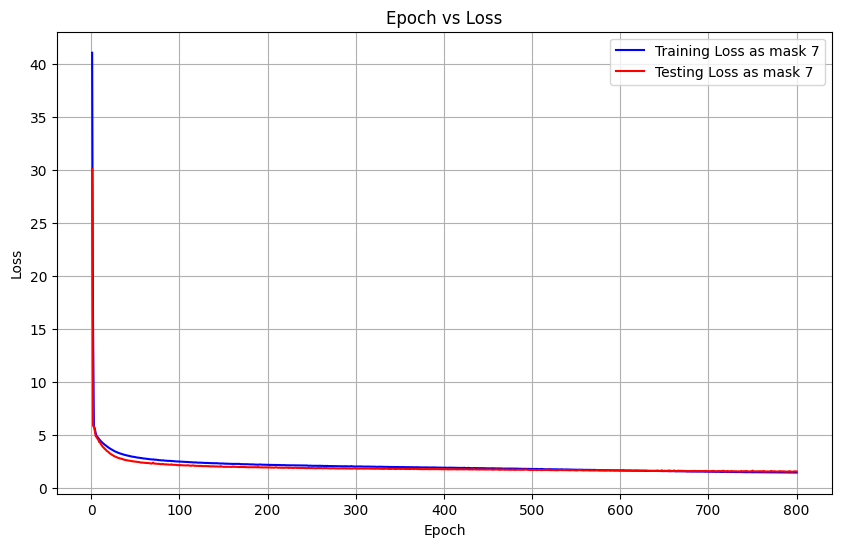

Test Loss: 1.5365269978841145
Correlation between actual labels and predicted values at mask 7: 0.8727479921205407
Mean Absolute Error (MAE) at mask 7: 0.8065280318260193
mask:  6


Training: 100%|██████████| 800/800 [1:28:49<00:00,  6.66s/it, test_loss=1.6159, train_loss=1.6542]


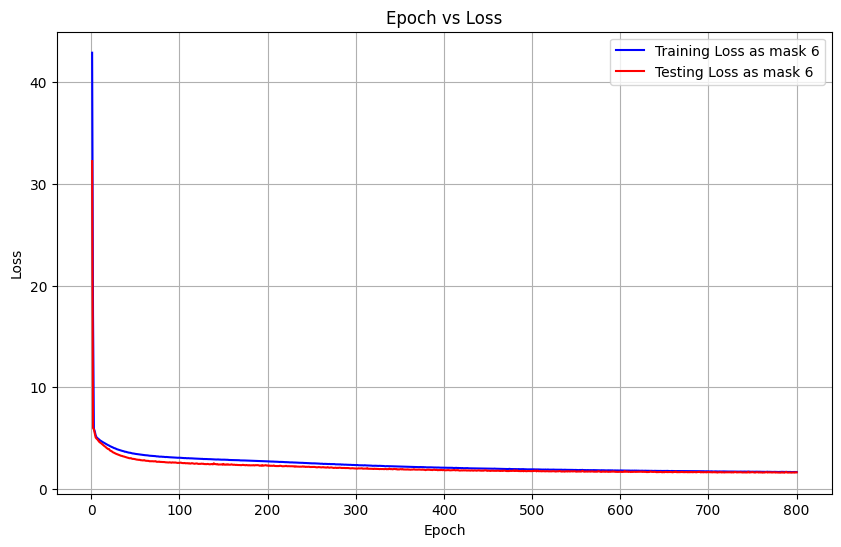

Test Loss: 1.5840529680252076
Correlation between actual labels and predicted values at mask 6: 0.8685023884504367
Mean Absolute Error (MAE) at mask 6: 0.821865975856781
mask:  5


Training: 100%|██████████| 800/800 [1:27:11<00:00,  6.54s/it, test_loss=2.1237, train_loss=2.3142]


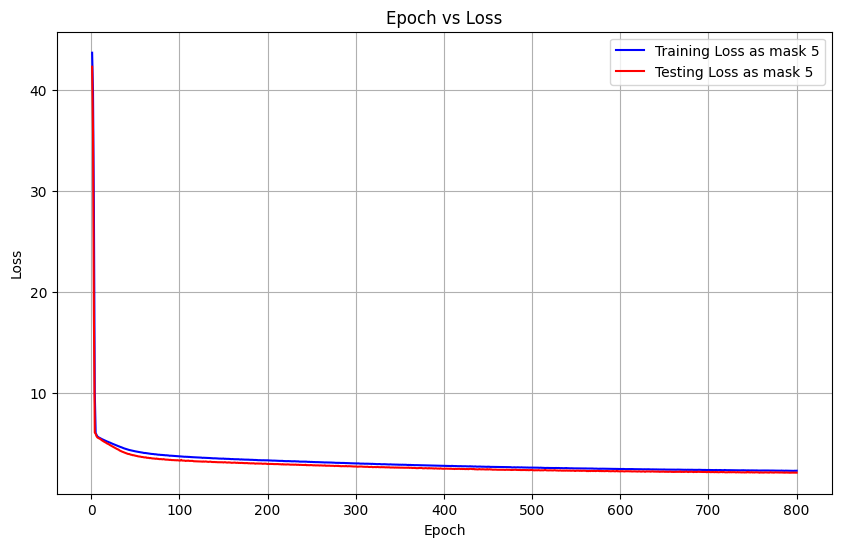

Test Loss: 2.116614659627279
Correlation between actual labels and predicted values at mask 5: 0.8210165243487367
Mean Absolute Error (MAE) at mask 5: 0.9883740544319153
mask:  4


Training: 100%|██████████| 800/800 [1:27:04<00:00,  6.53s/it, test_loss=2.5649, train_loss=3.0387]


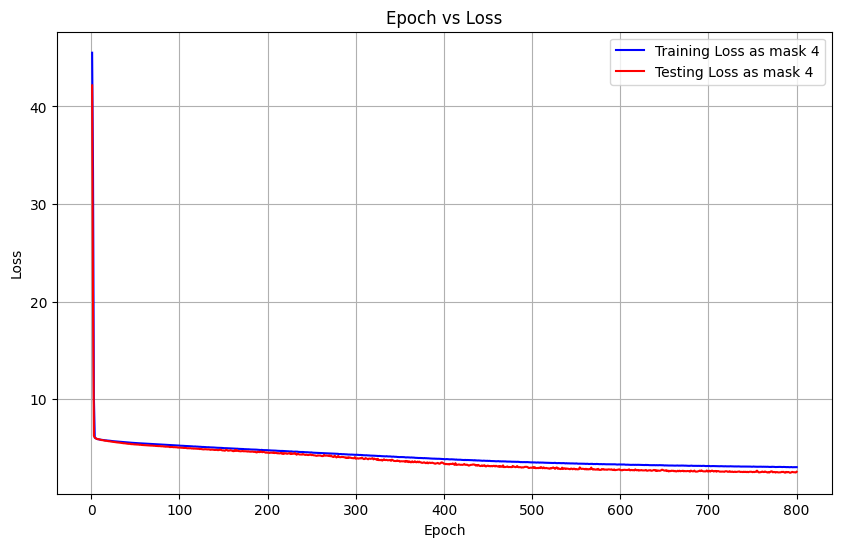

Test Loss: 2.4676592985788983
Correlation between actual labels and predicted values at mask 4: 0.780222808455672
Mean Absolute Error (MAE) at mask 4: 1.0894757509231567
mask:  3


Training: 100%|██████████| 800/800 [1:28:56<00:00,  6.67s/it, test_loss=2.0869, train_loss=2.2262]


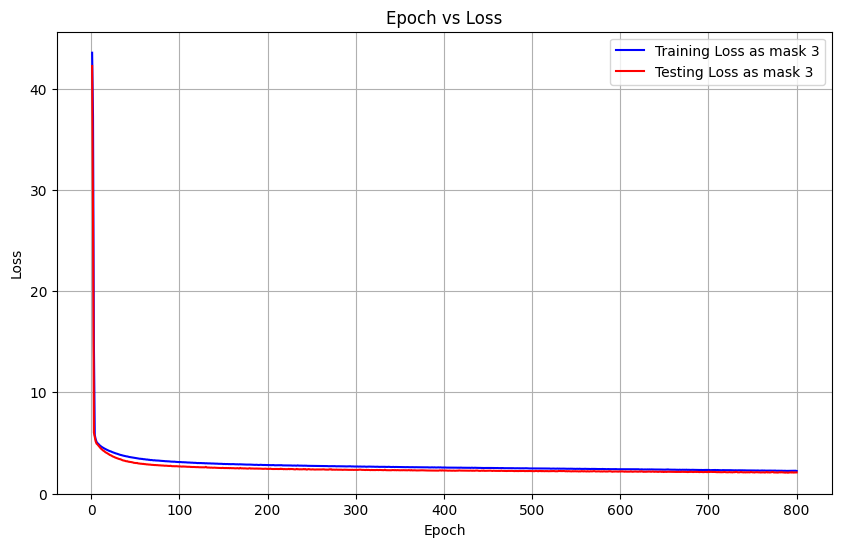

Test Loss: 2.055286407470703
Correlation between actual labels and predicted values at mask 3: 0.8221254729056842
Mean Absolute Error (MAE) at mask 3: 0.9660882353782654
mask:  2


Training: 100%|██████████| 800/800 [1:29:54<00:00,  6.74s/it, test_loss=2.8252, train_loss=3.2823]


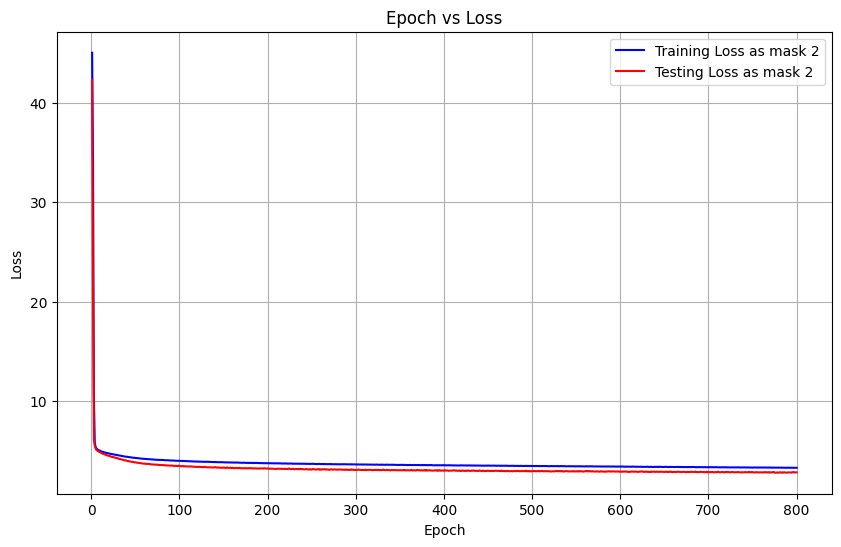

Test Loss: 2.788503630956014
Correlation between actual labels and predicted values at mask 2: 0.7411576096635574
Mean Absolute Error (MAE) at mask 2: 1.1741520166397095
mask:  1


Training: 100%|██████████| 800/800 [2:07:19<00:00,  9.55s/it, test_loss=5.0012, train_loss=5.0203]  


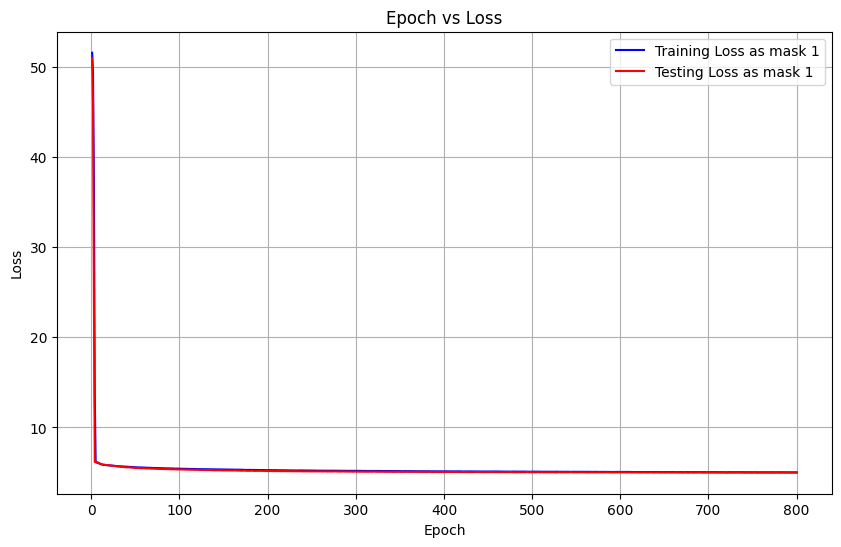

Test Loss: 4.982772986094157
Correlation between actual labels and predicted values at mask 1: 0.4238964656367251
Mean Absolute Error (MAE) at mask 1: 1.7102901935577393


In [97]:
# 模型训练
criterion = nn.MSELoss()

shap_df_final = None
for mask in range(7, 0, -1):
    def get_input(input_data, mask):
        res = []
        if mask >> 0 & 1:
            res.append(input_data[:, :image_dim])
        if mask >> 1 & 1:
            res.append(input_data[:, image_dim:image_dim+text_dim])
        if mask >> 2 & 1:
            res.append(input_data[:, image_dim+text_dim:])
        return torch.cat(res, dim=1)
    
    model = AllinOneMLP(image_dim, text_dim, user_dim, mask).to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)  # 使用L2正则化
    print("mask: ", mask)

    # 训练循环
    epoch_losses = []
    test_losses = []
    num_epochs = 800
    min_train_loss = 10 ** 10
    min_test_loss = 10 ** 10
    last_refresh_train = 0
    last_refresh_test = 0
    stop_threshold = 100
    clip_and_norm = False
    min_eps = 0.000001
    save_file_prefix = "46"

    # 循环处理每个epoch
    progress_bar = tqdm.tqdm(range(num_epochs), desc=f"Training")
    for epoch in progress_bar:

        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # 前向传播
            optimizer.zero_grad()
            outputs = model(get_input(inputs, mask))
            
            # 计算损失并反向传播
            negative_outputs = outputs[outputs < 0]
            loss = criterion(outputs, labels)
            loss.backward()

            # 梯度裁剪并更新网络
            if clip_and_norm:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
            optimizer.step()
            running_loss += loss.item()

        # 记录每个epoch的损失
        epoch_losses.append(running_loss / len(train_loader))
        # 测试模型
        model.eval()
        with torch.no_grad():
            total_loss = 0.0
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(get_input(inputs, mask))
                loss = criterion(outputs, labels)
                total_loss += loss.item()
            test_losses.append(total_loss/len(test_loader))
        if epoch_losses[-1] < min_train_loss:
            min_train_loss = epoch_losses[-1]
            last_refresh_train = epoch
            # 保存模型
            torch.save(model.state_dict(), f'model_training_mask_{mask}_{save_file_prefix}.pt')
        if test_losses[-1] < min_test_loss:
            min_test_loss = test_losses[-1]
            last_refresh = epoch
            # 保存模型
            torch.save(model.state_dict(), f'model_testing_mask_{mask}_{save_file_prefix}.pt')
        # if epoch - last_refresh_train > stop_threshold and epoch - last_refresh_test > stop_threshold or epoch >= stop_threshold and (sum(epoch_losses[-stop_threshold:-stop_threshold//2]) - sum(epoch_losses[-stop_threshold//2:]) < min_eps or sum(test_losses[-stop_threshold//2:]) - sum(test_losses[-stop_threshold:-stop_threshold//2]) > min_eps):
        #     break
        # 更新 tqdm 显示 loss
        progress_bar.set_postfix(train_loss=f"{epoch_losses[-1]:.4f}", test_loss=f"{test_losses[-1]:.4f}")
    
    # 加载模型
    model.load_state_dict(torch.load(f'model_testing_mask_{mask}_{save_file_prefix}.pt'))

    # 清除当前图形内容，并重新绘制损失曲线
    # 初始化图形
    plt.figure(figsize=(10, 6))
    plt.clf()
    plt.plot(range(1, epoch + 2), epoch_losses, color='b', label=f'Training Loss as mask {mask}')
    plt.plot(range(1, epoch + 2), test_losses, color='r', label=f'Testing Loss as mask {mask}')
    plt.title('Epoch vs Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.draw()  # 刷新图形

    # 完成后显示最终图表
    plt.show()

    print(f'Test Loss: {min_test_loss}')

    # 获取标签和预测值
    output_y_labels = y_test_tensor.clone()
    output_y_preds = model(get_input(X_test_tensor, mask))

    # 计算Spearman相关系数
    correlation, _ = spearmanr(output_y_labels.cpu().detach().numpy().flatten(), output_y_preds.cpu().detach().numpy().flatten())

    # 输出相关系数
    print(f'Correlation between actual labels and predicted values at mask {mask}: {correlation}')

    # 计算MAE
    mae = torch.mean(torch.abs(output_y_labels - output_y_preds))
    print(f'Mean Absolute Error (MAE) at mask {mask}: {mae.item()}')

In [103]:
import shap
import torch
import numpy as np
import pandas as pd

sample_size = 4096 * 8  # 采样数量
K_means_k = 128
mask = 7

# 使用DeepExplainer替换KernelExplainer
def get_shap_values(model, X_train_tensor, X_test_tensor, mask, sample_size=100, K_means_k=10, device='cuda'):
    # 准备背景数据（直接使用采样后的tensor，无需KMeans）
    background_indices = np.random.choice(len(X_train_tensor), size=min(sample_size, len(X_train_tensor)), replace=False)
    background_data = get_input(X_train_tensor[background_indices], mask).to(device)

    # 初始化 GradientExplainer
    explainer = shap.GradientExplainer(model, background_data)

    # 准备测试数据（保持tensor格式）
    test_indices = np.random.choice(len(X_test_tensor), size=min(sample_size, len(X_test_tensor)), replace=False)
    test_data = get_input(X_test_tensor[test_indices], mask).to(device)

    # 计算SHAP值（自动处理设备转换）
    shap_values = explainer.shap_values(test_data)

    # 处理输出格式
    if isinstance(shap_values, list):
        shap_values = np.array(shap_values)
    
    # 调整维度 (假设单输出模型)
    shap_values = shap_values.squeeze(axis=2) if len(shap_values.shape) == 3 else shap_values
    print(f"SHAP值原始维度: {shap_values.shape}")

    # 保存中间结果
    pd.DataFrame(shap_values).to_csv(f'shap_values_{save_file_prefix}_mask_{mask}_before.csv', index=False)

    # 计算特征重要性均值
    mean_shap = np.mean(shap_values, axis=0)
    result_df = pd.DataFrame(mean_shap, columns=["shap_value"])

    # 添加特征名称
    feat_names = []
    if mask & 0b001:  # 更易读的位运算
        feat_names.extend(X_feat_name['image'])
    if mask & 0b010:
        feat_names.extend(X_feat_name['text'])
    if mask & 0b100:
        feat_names.extend(X_feat_name['user'])
    
    result_df['feature'] = feat_names
    result_df.to_csv(f'shap_values_{save_file_prefix}_mask_{mask}_after.csv', index=False)
    return result_df


# 转换为评估模式
model = AllinOneMLP(image_dim, text_dim, user_dim, 7).to(device)
model.load_state_dict(torch.load(f'model_testing_mask_7_{save_file_prefix}.pt'))
model.eval()
shap_values = get_shap_values(model, X_train_tensor, X_test_tensor, 7, sample_size=sample_size, K_means_k=K_means_k, device=device)

# 按A列分组并计算B列的均值，重置索
result = shap_values.groupby('feature', sort=False)['shap_value'].mean().reset_index()
result['shap_value'] = result['shap_value'].abs()
result = result.sort_values(by='shap_value', ascending=False)

# 打印结果
print(result)

# 可选：将结果保存到新CSV文件
result.to_csv(f'output_{save_file_prefix}.csv', index=False)

SHAP值原始维度: (32768, 212)
                         feature  shap_value
47           all_tags_word_count    0.004671
40  user_description_digit_count    0.002718
36   user_description_word_count    0.002584
62                         ispro    0.002549
35   user_description_char_count    0.002240
..                           ...         ...
17                       entropy    0.000031
53           all_tags_verb_ratio    0.000028
75                  Latitude_spv    0.000025
2                       red_mean    0.000016
32              title_verb_ratio    0.000013

[77 rows x 2 columns]


number of parameters:  448632


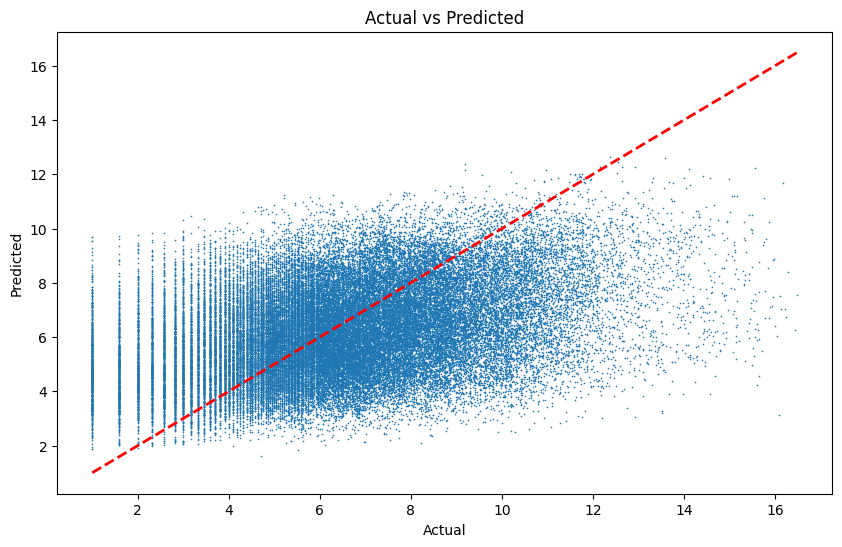

In [118]:
import random

import matplotlib.pyplot as plt

# 使用模型进行预测
model = AllinOneMLP(image_dim, text_dim, user_dim, 7).to(device)
model.load_state_dict(torch.load(f'model_testing_mask_7_{save_file_prefix}.pt'))
num_params = sum(p.numel() for p in model.parameters())
print("number of parameters: ", num_params)
model.eval()
with torch.no_grad():
    X_test_tensor_scatter_preds = model(get_input(X_test_tensor, 7))

# 将预测结果与实际值进行比较，并可视化
X_test_tensor_scatter_preds = X_test_tensor_scatter_preds.cpu().numpy()
# y_train_tensor = y_train_tensor.numpy()

# 可视化回归结果
plt.figure(figsize=(10, 6))
plt.scatter(y_test_tensor.to("cpu"), X_test_tensor_scatter_preds, alpha=1, linewidths=0.1, s=1)
plt.plot([y_test_tensor.to("cpu").min(), y_test_tensor.to("cpu").max()], [y_test_tensor.to("cpu").min(), y_test_tensor.to("cpu").max()], 'r--', lw=2)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.show()

In [ ]:
# 消融实验

# 1. 去掉dropout
# 2. 去掉残差连接
# 3. 去掉transformermlp
# 4. 去掉transformer
# 5. 去掉mlp（保留transformer+一个fc）
# 6. 去掉SEBlock

# 🔹 Transformer + MLP
class TransformerMLPModelAblation(nn.Module):
    def __init__(self, input_dim=216, num_heads=3, transformer_hidden_dim=512, 
                 mlp_hidden_dims=[128, 64, 32, 8], output_dim=1, dropout=0.1,
                 need_se_block=True, need_transformer=True, need_mlp=True):
        super(TransformerMLPModelAblation, self).__init__()
        num_heads = 10
        while input_dim % num_heads:
            num_heads -= 1

        self.se_block = SEBlock(input_dim)  # 通道注意力模块
        self.transformer = TransformerEncoderBlock(input_dim, num_heads, transformer_hidden_dim, dropout)
        self.need_se_block = need_se_block
        self.need_transformer = need_transformer
        self.need_mlp = need_mlp
        if self.need_mlp:
            self.mlp = MLP(input_dim, mlp_hidden_dims, output_dim)  # 最终预测
        else:
            self.mlp = nn.Linear(input_dim, output_dim)  # 最终预测
        self.need_se_block = need_se_block
        self.need_transformer = need_transformer
        self.need_mlp = need_mlp

    def forward(self, x):
        if self.need_se_block:
            x = self.se_block(x)  # 先调整 A+B 特征的权重
        if self.need_transformer:
            x = x.unsqueeze(0)  # Transformer 输入要求 (seq_len, batch_size, input_dim)
            x = self.transformer(x)
            x = x.squeeze(0)  # 变回 (batch_size, input_dim)
        return self.mlp(x)

class WithoutDropout(nn.Module):
    def __init__(self, image_dim, text_dim, user_dim, mask, dropout_rate=0):
        super(WithoutDropout, self).__init__()

        self.mask = mask
        dims = [image_dim, text_dim, user_dim]
        total_dims = sum([dims[i] for i in range(len(dims)) if mask >> i & 1])
        
        self.trans_mlp = TransformerMLPModel(input_dim=total_dims, dropout=dropout_rate)
        self.residual = nn.Linear(total_dims, 1)  # 残差连接，确保 B 影响力不变
        self.dropout = nn.Dropout(p=dropout_rate)  # Feature Dropout

    def forward(self, x):
        x = self.dropout(x)  # Dropout 让模型不依赖 A
        return self.trans_mlp(x) + self.residual(x)  # 残差连接，确保 B 信息不会丢失

class WithoutResidual(nn.Module):
    def __init__(self, image_dim, text_dim, user_dim, mask, dropout_rate=0.2):
        super(WithoutResidual, self).__init__()

        self.mask = mask
        dims = [image_dim, text_dim, user_dim]
        total_dims = sum([dims[i] for i in range(len(dims)) if mask >> i & 1])
        
        self.trans_mlp = TransformerMLPModel(input_dim=total_dims)
        self.residual = nn.Linear(total_dims, 1)  # 残差连接，确保 B 影响力不变
        self.dropout = nn.Dropout(p=dropout_rate)  # Feature Dropout

    def forward(self, x):
        x = self.dropout(x)  # Dropout 让模型不依赖 A
        return self.trans_mlp(x) # + self.residual(x)  # 残差连接，确保 B 信息不会丢失

class WithoutTransformerMLP(nn.Module):
    def __init__(self, image_dim, text_dim, user_dim, mask, dropout_rate=0.2):
        super(WithoutTransformerMLP, self).__init__()

        self.mask = mask
        dims = [image_dim, text_dim, user_dim]
        total_dims = sum([dims[i] for i in range(len(dims)) if mask >> i & 1])
        
        self.trans_mlp = TransformerMLPModel(input_dim=total_dims)
        self.residual = nn.Linear(total_dims, 1)  # 残差连接，确保 B 影响力不变
        self.dropout = nn.Dropout(p=dropout_rate)  # Feature Dropout

    def forward(self, x):
        x = self.dropout(x)  # Dropout 让模型不依赖 A
        return self.residual(x)

class WithoutTransformer(nn.Module):
    def __init__(self, image_dim, text_dim, user_dim, mask, dropout_rate=0.2):
        super(WithoutTransformer, self).__init__()

        self.mask = mask
        dims = [image_dim, text_dim, user_dim]
        total_dims = sum([dims[i] for i in range(len(dims)) if mask >> i & 1])
        
        self.trans_mlp = TransformerMLPModelAblation(input_dim=total_dims, need_transformer=False)
        self.residual = nn.Linear(total_dims, 1)  # 残差连接，确保 B 影响力不变
        self.dropout = nn.Dropout(p=dropout_rate)  # Feature Dropout

    def forward(self, x):
        x = self.dropout(x)  # Dropout 让模型不依赖 A
        return self.trans_mlp(x) + self.residual(x)  # 残差连接，确保 B 信息不会丢失

class WithoutMLP(nn.Module):
    def __init__(self, image_dim, text_dim, user_dim, mask, dropout_rate=0.2):
        super(WithoutMLP, self).__init__()

        self.mask = mask
        dims = [image_dim, text_dim, user_dim]
        total_dims = sum([dims[i] for i in range(len(dims)) if mask >> i & 1])
        
        self.trans_mlp = TransformerMLPModelAblation(input_dim=total_dims, need_mlp=False)
        self.residual = nn.Linear(total_dims, 1)  # 残差连接，确保 B 影响力不变
        self.dropout = nn.Dropout(p=dropout_rate)  # Feature Dropout

    def forward(self, x):
        x = self.dropout(x)  # Dropout 让模型不依赖 A
        return self.trans_mlp(x) + self.residual(x)  # 残差连接，确保 B 信息不会丢失

class WithoutSEBlock(nn.Module):
    def __init__(self, image_dim, text_dim, user_dim, mask, dropout_rate=0.2):
        super(WithoutSEBlock, self).__init__()

        self.mask = mask
        dims = [image_dim, text_dim, user_dim]
        total_dims = sum([dims[i] for i in range(len(dims)) if mask >> i & 1])
        
        self.trans_mlp = TransformerMLPModelAblation(input_dim=total_dims, need_se_block=False)
        self.residual = nn.Linear(total_dims, 1)  # 残差连接，确保 B 影响力不变
        self.dropout = nn.Dropout(p=dropout_rate)  # Feature Dropout

    def forward(self, x):
        x = self.dropout(x)  # Dropout 让模型不依赖 A
        return self.trans_mlp(x) + self.residual(x)  # 残差连接，确保 B 信息不会丢失



In [ ]:
wo_dropoout_model = WithoutDropout(image_dim, text_dim, user_dim, 7)
wo_residual_model = WithoutResidual(image_dim, text_dim, user_dim, 7)
wo_transformermlp_model = WithoutTransformerMLP(image_dim, text_dim, user_dim, 7)
wo_transformer_model = WithoutTransformer(image_dim, text_dim, user_dim, 7)
wo_mlp_model = WithoutMLP(image_dim, text_dim, user_dim, 7)
wo_seblock_model = WithoutSEBlock(image_dim, text_dim, user_dim, 7)

Training model wo_dropoout_model: 100%|██████████| 800/800 [1:37:52<00:00,  7.34s/it, test_loss=1.9448, train_loss=0.5706]


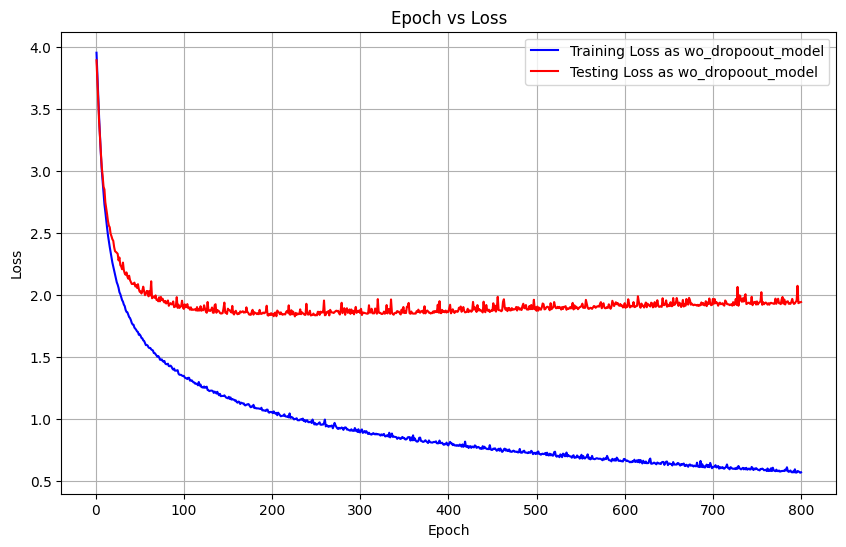

Test Loss: 1.8284155448277792
Correlation between actual labels and predicted values at wo_dropoout_model: 0.8445114282770005
Mean Absolute Error (MAE) at wo_dropoout_model: 0.8587974309921265


Training model wo_residual_model: 100%|██████████| 800/800 [2:20:46<00:00, 10.56s/it, test_loss=1.5416, train_loss=1.3700]    


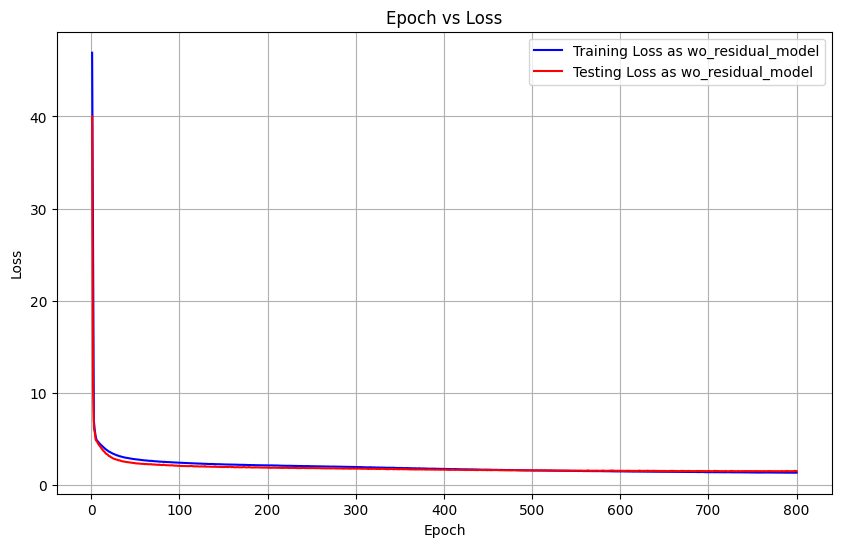

Test Loss: 1.5160085360209148
Correlation between actual labels and predicted values at wo_residual_model: 0.8748042316194761
Mean Absolute Error (MAE) at wo_residual_model: 0.7926945090293884


Training model wo_transformermlp_model: 100%|██████████| 800/800 [1:41:04<00:00,  7.58s/it, test_loss=4.7549, train_loss=4.9559] 


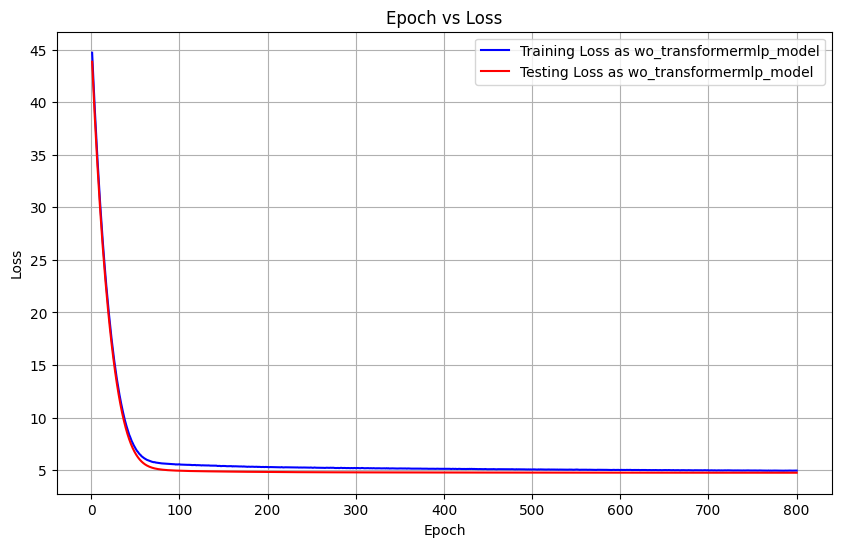

Test Loss: 4.75455888112386
Correlation between actual labels and predicted values at wo_transformermlp_model: 0.4715056170928901
Mean Absolute Error (MAE) at wo_transformermlp_model: 1.7222754955291748


Training model wo_transformer_model: 100%|██████████| 800/800 [1:38:58<00:00,  7.42s/it, test_loss=2.2197, train_loss=2.5365]


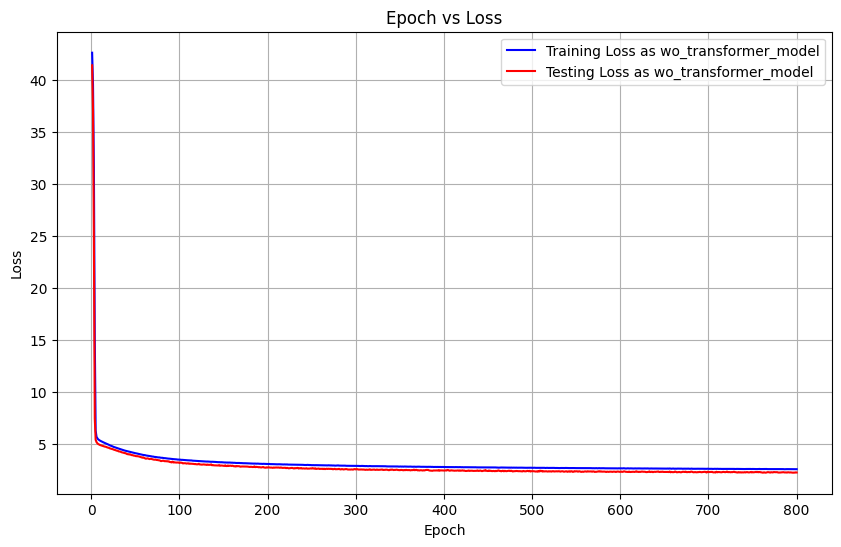

Test Loss: 2.198308324813843
Correlation between actual labels and predicted values at wo_transformer_model: 0.8066993338053224
Mean Absolute Error (MAE) at wo_transformer_model: 1.0117852687835693


Training model wo_mlp_model: 100%|██████████| 800/800 [2:06:41<00:00,  9.50s/it, test_loss=1.6654, train_loss=1.5465]   


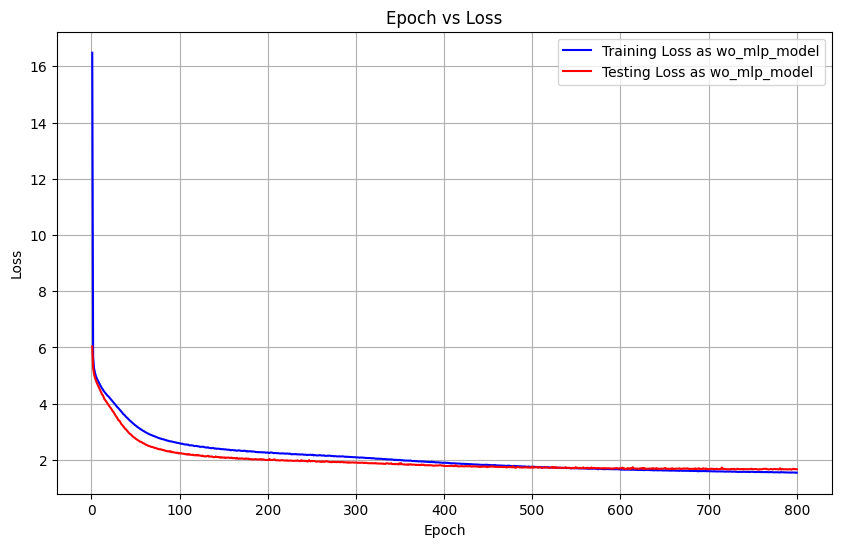

Test Loss: 1.6543726841608684
Correlation between actual labels and predicted values at wo_mlp_model: 0.8715826108283686
Mean Absolute Error (MAE) at wo_mlp_model: 0.8766353726387024


Training model wo_seblock_model: 100%|██████████| 800/800 [2:54:20<00:00, 13.08s/it, test_loss=1.7648, train_loss=1.7891]    


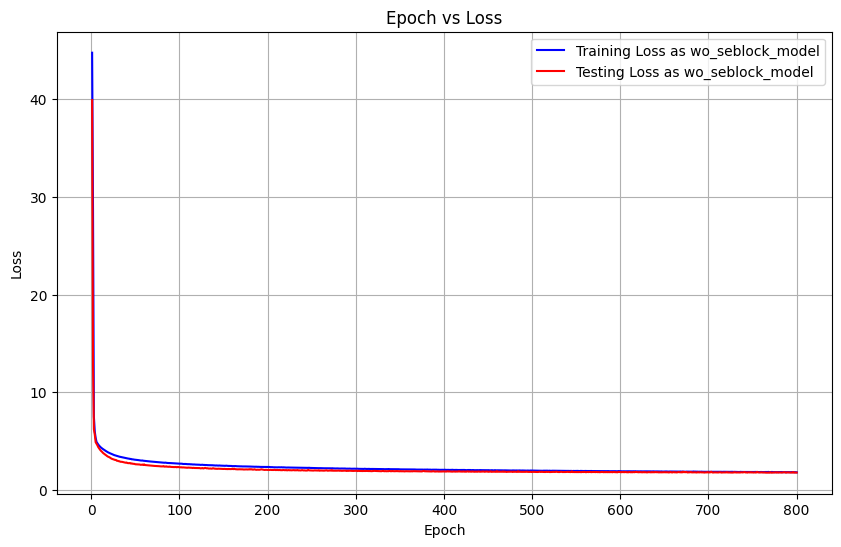

Test Loss: 1.7480923732121785
Correlation between actual labels and predicted values at wo_seblock_model: 0.8525051861720873
Mean Absolute Error (MAE) at wo_seblock_model: 0.8737391829490662


In [112]:
# 模型训练
criterion = nn.MSELoss()

models = [wo_dropoout_model, wo_residual_model, wo_transformermlp_model, wo_transformer_model, wo_mlp_model, wo_seblock_model]
model_names = ["wo_dropoout_model", "wo_residual_model", "wo_transformermlp_model", "wo_transformer_model", "wo_mlp_model", "wo_seblock_model"]
for model, model_name in zip(models, model_names):
    model = model.to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-4, weight_decay=5e-4)  # 使用L2正则化

    # 训练循环
    epoch_losses = []
    test_losses = []
    num_epochs = 800
    min_train_loss = 10 ** 10
    min_test_loss = 10 ** 10
    last_refresh_train = 0
    last_refresh_test = 0
    stop_threshold = 100
    clip_and_norm = False
    min_eps = 0.000001
    save_file_prefix = "46"

    # 循环处理每个epoch
    progress_bar = tqdm.tqdm(range(num_epochs), desc=f"Training model {model_name}")
    for epoch in progress_bar:
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # 前向传播
            optimizer.zero_grad()
            outputs = model(get_input(inputs, mask))
            
            # 计算损失并反向传播
            negative_outputs = outputs[outputs < 0]
            loss = criterion(outputs, labels)
            loss.backward()

            # 梯度裁剪并更新网络
            if clip_and_norm:
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=0.1)
            optimizer.step()
            running_loss += loss.item()

        # 记录每个epoch的损失
        epoch_losses.append(running_loss / len(train_loader))
        # 测试模型
        model.eval()
        with torch.no_grad():
            total_loss = 0.0
            for inputs, labels in test_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(get_input(inputs, mask))
                loss = criterion(outputs, labels)
                total_loss += loss.item()
            test_losses.append(total_loss/len(test_loader))
        if epoch_losses[-1] < min_train_loss:
            min_train_loss = epoch_losses[-1]
            last_refresh_train = epoch
            # 保存模型
            torch.save(model.state_dict(), f'{model_name}_training_{save_file_prefix}.pt')
        if test_losses[-1] < min_test_loss:
            min_test_loss = test_losses[-1]
            last_refresh = epoch
            # 保存模型
            torch.save(model.state_dict(), f'{model_name}_testing_{save_file_prefix}.pt')
        # if epoch - last_refresh_train > stop_threshold and epoch - last_refresh_test > stop_threshold or epoch >= stop_threshold and (sum(epoch_losses[-stop_threshold:-stop_threshold//2]) - sum(epoch_losses[-stop_threshold//2:]) < min_eps or sum(test_losses[-stop_threshold//2:]) - sum(test_losses[-stop_threshold:-stop_threshold//2]) > min_eps):
        #     break
        # 更新 tqdm 显示 loss
        progress_bar.set_postfix(train_loss=f"{epoch_losses[-1]:.4f}", test_loss=f"{test_losses[-1]:.4f}")

    # 加载模型
    model.load_state_dict(torch.load(f'{model_name}_testing_{save_file_prefix}.pt'))

    # 绘制训练和测试损失
    plt.figure(figsize=(10, 6))
    plt.clf()
    plt.plot(range(1, epoch + 2), epoch_losses, color='b', label=f'Training Loss as {model_name}')
    plt.plot(range(1, epoch + 2), test_losses, color='r', label=f'Testing Loss as {model_name}')
    plt.title('Epoch vs Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.legend()
    plt.draw()  # 刷新图形

    # 完成后显示最终图表
    plt.show()

    print(f'Test Loss: {min_test_loss}')

    # 获取标签和预测值
    output_y_labels = y_test_tensor.clone()
    output_y_preds = model(get_input(X_test_tensor, mask))

    # 计算Spearman相关系数
    correlation, _ = spearmanr(output_y_labels.cpu().detach().numpy().flatten(), output_y_preds.cpu().detach().numpy().flatten())

    # 输出相关系数
    print(f'Correlation between actual labels and predicted values at {model_name}: {correlation}')

    # 计算MAE
    mae = torch.mean(torch.abs(output_y_labels - output_y_preds))
    print(f'Mean Absolute Error (MAE) at {model_name}: {mae.item()}')

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind
from sklearn.tree import DecisionTreeRegressor
from sklearn.decomposition import PCA
import torch
# import ace_tools as tools

# 复制变量，确保原数据不受影响
y_test_tensor_cpu = y_test_tensor.cpu().numpy().copy()
X_test_tensor_scatter_preds_copy = X_test_tensor_scatter_preds.copy()
X_test_tensor_copy = X_test_tensor.cpu().numpy().copy()

# 计算误差
feature_names = result['feature'].tolist()
df_test = pd.DataFrame(X_test_tensor_copy, columns=feature_names)
df_test['y_true'] = y_test_tensor_cpu
df_test['y_pred'] = X_test_tensor_scatter_preds_copy
df_test['error'] = np.abs(df_test['y_true'] - df_test['y_pred'])

median_error = np.median(df_test['error'])
low_error_samples = df_test[df_test['error'] <= median_error]
high_error_samples = df_test[df_test['error'] > median_error]

# 计算特征统计信息
feature_stats = []
for col in feature_names:
    mean_low = low_error_samples[col].mean()
    mean_high = high_error_samples[col].mean()
    p_value = ttest_ind(low_error_samples[col], high_error_samples[col], equal_var=False).pvalue
    feature_stats.append([col, mean_low, mean_high, p_value])

feature_analysis = pd.DataFrame(feature_stats, columns=['Feature', 'Mean_Low_Error', 'Mean_High_Error', 'P_Value'])

# 显示特征分析结果
tools.display_dataframe_to_user("Feature Analysis", feature_analysis)

# 训练决策树分析特征重要性
X = df_test[feature_names].copy()
y = df_test['error'].copy()
regressor = DecisionTreeRegressor(max_depth=3, random_state=42)
regressor.fit(X, y)
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': regressor.feature_importances_})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# PCA降维
df_test_pca = PCA(n_components=2).fit_transform(X)
df_test['PCA1'], df_test['PCA2'] = df_test_pca[:, 0], df_test_pca[:, 1]

# 绘制 PCA 结果
plt.figure(figsize=(8, 6))
plt.scatter(df_test[df_test['error'] <= median_error]['PCA1'], df_test[df_test['error'] <= median_error]['PCA2'], label='Low Error', alpha=0.5)
plt.scatter(df_test[df_test['error'] > median_error]['PCA1'], df_test[df_test['error'] > median_error]['PCA2'], label='High Error', alpha=0.5, color='red')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.title('PCA Projection of Low and High Error Samples')
plt.legend()
plt.show()

Defaulting to user installation because normal site-packages is not writeable


ValueError: Shape of passed values is (61123, 212), indices imply (61123, 77)